In [1]:
# demo using ResNet-18 model with cifar 10 dataset
import os
import numpy as np 
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn 
from torch.utils.data import DataLoader
from torch.autograd import grad 
import torchvision 
import torchvision.models as models 
from torchvision import datasets, transforms 
from torchvision.utils import save_image 
import inversefed 
from models.cifar10_models.resnet import resnet18
# trained cifar model can get from https://github.com/huyvnphan/PyTorch_CIFAR10
from utils.stackeddata import StackedData

# gpu 
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'

In [2]:
data_root = 'data/cifar_data' # dir to store cifar data 
cifar_mean, cifar_std = inversefed.consts.cifar10_mean, inversefed.consts.cifar10_std
dm = torch.as_tensor(cifar_mean)[:, None, None].to(device)
ds = torch.as_tensor(cifar_std)[:, None, None].to(device)
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(cifar_mean, cifar_std)])
test_dataset = datasets.CIFAR10(root=data_root, download=False, train=False, transform=transform)
data_shape = (3, 32, 32)
classes = test_dataset.classes
model = resnet18(pretrained=True) # pretrained=True, load trained model 
model = model.to(device)
model.eval()
criterion = nn.CrossEntropyLoss() 

Ground truth label: airplane Ground truth model prediction: ship


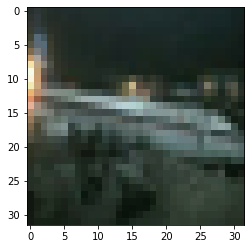

In [3]:
idx = 1001 # idx of test data with wrong pred
gt_data, gt_label = test_dataset[idx]
gt_data = gt_data.unsqueeze(dim=0).to(device)
with torch.no_grad(): 
    model.zero_grad() 
    gt_prediction = model(gt_data)

# original data 
plt.imshow((gt_data[0].cpu() * ds.cpu() + dm.cpu()).permute(1,2,0))
print('Ground truth label: {} Ground truth model prediction: {}'.format(classes[gt_label], classes[torch.max(gt_prediction, axis=1)[1]]))

In [4]:
# create stacked data
stacked = StackedData(stack_size=4, model_name='resnet18', dataset_name='cifar10', dataset=test_dataset, save_output=True, device=device) 
stack_data = stacked.create_stacked_data([idx])

for i in range(len(stack_data['gt_img'])): 
    gt_img, gt_label = stack_data['gt_img'][i], stack_data['gt_label'][i]
    stack_pred = model(gt_img)
    target_loss = criterion(stack_pred, gt_label)
    input_grad = grad(target_loss, model.parameters())
    input_grad =[grad.detach() for grad in input_grad]
    config = dict(signed=True,
              boxed=False,
              cost_fn='sim',
              indices='def',
              norm='none',
              weights='equal',
              lr=0.1, 
              optim='adam',
              restarts=1,
              max_iterations=1200,
              total_variation=0.1,
              init='randn',
              filter='none',
              lr_decay=True,
              scoring_choice='loss')
    
    # inverting gradients 
    rec_machine = inversefed.GradientReconstructor(model, (dm, ds), config, num_images=gt_img.shape[0])
    results = rec_machine.reconstruct(input_grad, gt_label, gt_img ,img_shape=data_shape)
    output_img, stats = results

Predictions for recontructed images:  ['airplane', 'ship', 'airplane', 'airplane']


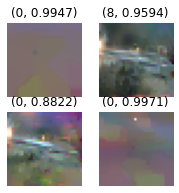

In [5]:
with torch.no_grad(): 
    rec_pred = model(output_img)
    print('Predictions for recontructed images: ', [classes[l] for l in torch.max(rec_pred, axis=1)[1]])
    stacked.grid_plot(idx, output_img, rec_pred, dm, ds)